In [2]:

import os
import asyncio
import subprocess
from typing import Any, Dict

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pycocotools import mask as mask_util
from tqdm import tqdm
import video_prep
import json

import sanity_check


In [50]:
def bitget(val, idx):
    return (val >> idx) & 1


def pascal_color_map():
    colormap = np.zeros((512, 3), dtype=int)
    ind = np.arange(512, dtype=int)
    for shift in reversed(list(range(8))):
        for channel in range(3):
            colormap[:, channel] |= bitget(ind, channel) << shift
        ind >>= 3

    return colormap.astype(np.uint8)


def draw_masks_to_frame(
    frame: np.ndarray, masks: np.ndarray, colors: np.ndarray
) -> np.ndarray:
    masked_frame = frame
    for mask, color in zip(masks, colors):
        curr_masked_frame = np.where(mask[..., None], color, masked_frame)
        masked_frame = cv2.addWeighted(masked_frame, 0.75, curr_masked_frame, 0.25, 0)

        if int(cv2.__version__[0]) > 3:
            contours, _ = cv2.findContours(
                np.array(mask, dtype=np.uint8).copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE
            )
        else:
            _, contours, _ = cv2.findContours(
                np.array(mask, dtype=np.uint8).copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE
            )

        cv2.drawContours(masked_frame, contours, -1, (255, 255, 255), 7)  # White outer contour
        cv2.drawContours(masked_frame, contours, -1, (0, 0, 0), 5)  # Black middle contour
        cv2.drawContours(masked_frame, contours, -1, color.tolist(), 3)  # Original color inner contour
    return masked_frame

def get_rle(df, saco_yt1b_id, masklet_id, frame_num):
    video_df = df[df.video_id == saco_yt1b_id]
    masklet_df = video_df[video_df.masklet_id == masklet_id]
    assert len(masklet_df) == 1, f"Expected 1 masklet, got {len(masklet_df)}"
    masklet_row = masklet_df.iloc[0]

    rle = masklet_row.segmentations[frame_num]
    return rle
    
COLORS = pascal_color_map()[1:]

In [53]:
def plot_images(saco_yt1b_id, masklet_id, frame_num, df):
    frames_by_frame_matching = f"/home/tym/code/git_clone/sam3_and_data/data/media/saco_yt1b/frames_by_frame_matching/{saco_yt1b_id}/{frame_num:05d}.jpg"
    frames_by_start_end_timestamp_one_step = f"/home/tym/code/git_clone/sam3_and_data/data/media/saco_yt1b/frames_by_start_end_timestamp_one_step/{saco_yt1b_id}/{frame_num:05d}.jpg"
    frames_by_start_end_timestamp_two_step = f"/home/tym/code/git_clone/sam3_and_data/data/media/saco_yt1b/frames_by_start_end_timestamp_two_step/{saco_yt1b_id}/{frame_num:05d}.jpg"
    print(frames_by_frame_matching)
    print(frames_by_start_end_timestamp_one_step)
    print(frames_by_start_end_timestamp_two_step)

    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    
    for i, frame_path in enumerate([frames_by_frame_matching, frames_by_start_end_timestamp_one_step, frames_by_start_end_timestamp_two_step]):
        im = cv2.imread(frame_path)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

        axes[0, i].imshow(im)
        axes[0, i].set_title(f"Frame by {frame_path.split('/')[-3]}")
        axes[0, i].axis('off')

        masks = np.array([
            mask_util.decode(get_rle(df, saco_yt1b_id, masklet_id=masklet_id, frame_num=frame_num))
        ])
            

        # masks = np.array([mask_util.decode(rle) for rle in [masklet[frame_num]]])
        masked_frame = draw_masks_to_frame(
            frame=im, masks=masks, colors=COLORS[: len(masks)]
        )
        
        axes[1, i].imshow(masked_frame)
        axes[1, i].set_title(f"Masked Frame by {frame_path.split('/')[-3]}")
        axes[1, i].axis('off')


In [56]:
with open("/home/tym/code/git_clone/sam3_and_data/data/annotation/saco_veval_yt1b_test.json", "r") as f:
    data = json.load(f)

video_df = pd.DataFrame(data["videos"])
annot_df = pd.DataFrame(data["annotations"])
pair_df = pd.DataFrame(data["video_np_pairs"])

annot_df["masklet_id"] = annot_df.groupby("video_id").cumcount()
annot_df

id                                      segmentations  \
0        0  [None, None, None, None, None, None, None, Non...   
1        1  [None, None, None, None, None, {'counts': 'Vf_...   
2        2  [{'counts': 'k2d9\900000O100000000000000000000...   
3        3  [{'counts': 'd`g;=n0E^O6Z`0J[_Oe00E6k0j?o1H:bN...   
4        4  [None, None, None, None, None, None, None, Non...   
...    ...                                                ...   
4105  4105  [None, None, None, {'counts': 'dc`41lb03O2O0O1...   
4106  4106  [None, None, None, None, None, None, None, Non...   
4107  4107  [{'counts': '[hSb03kb02N3N1O101M2O1O1O1O2N101N...   
4108  4108  [{'counts': 'YSm32eb0O^]O7OO00\a0Le^ON0101Nm00...   
4109  4109  [None, None, None, None, None, None, None, Non...   

                                                 bboxes  \
0     [None, None, None, None, None, None, None, Non...   
1     [None, None, None, None, None, [1050.0, 152.0,...   
2     [[0.0, 90.0, 272.0, 309.0], [0.0, 89.0, 241.0,...   
3     [[632.0, 144.0, 291.0, 247.0], [601.0, 145.0, ...   
4     [None, None, None, None, None, None, None, Non...   
...                                                 ...   
4105  [None, None, None, [243.0, 323.0, 31.0, 19.0],...   
4106  [None, None, None, None, None, None, None, Non...   
4107  [[976.0, 170.0, 104.0, 117.0], [951.0, 166.0, ...   
4108  [[210.0, 6.0, 870.0, 602.0], [198.0, 6.0, 882....   
4109  [None, None, None, None, None, None, None, Non...   

                                                  areas  iscrowd  \
0     [None, None, None, None, None, None, None, Non...        0   
1     [None, None, None, None, None, 6318.0, 12451.0...        0   
2     [47420.0, 37659.0, 28538.0, 24219.0, 21221.0, ...        0   
3     [66956.0, 66198.0, 66072.0, 65772.0, 65628.0, ...        0   
4     [None, None, None, None, None, None, None, Non...        0   
...                                                 ...      ...   
4105  [None, None, None, 134.0, 237.0, 207.0, 251.0,...        0   
4106  [None, None, None, None, None, None, None, Non...        0   
4107  [7739.0, 10945.0, 13839.0, 16232.0, 19770.0, 2...        0   
4108  [321408.0, 326017.0, 323031.0, 312926.0, 31534...        0   
4109  [None, None, None, None, None, None, None, Non...        0   

              video_id  height  width  category_id    noun_phrase  masklet_id  
0     saco_yt1b_000403     608   1080         7819    a back door           0  
1     saco_yt1b_000403     608   1080         7819    a back door           1  
2     saco_yt1b_000403     608   1080         7819    a back door           2  
3     saco_yt1b_000403     608   1080         7819    a back door           3  
4     saco_yt1b_000403     608   1080         7819    a back door           4  
...                ...     ...    ...          ...            ...         ...  
4105  saco_yt1b_000316     608   1080        34314  yellow square          28  
4106  saco_yt1b_000316     608   1080        34314  yellow square          29  
4107  saco_yt1b_000367     608   1080        43822          zebra           0  
4108  saco_yt1b_000367     608   1080        43822          zebra           1  
4109  saco_yt1b_000367     608   1080        43822          zebra           2  

[4110 rows x 11 columns]

/home/tym/code/git_clone/sam3_and_data/data/media/saco_yt1b/frames_by_frame_matching/saco_yt1b_000403/00000.jpg
/home/tym/code/git_clone/sam3_and_data/data/media/saco_yt1b/frames_by_start_end_timestamp_one_step/saco_yt1b_000403/00000.jpg
/home/tym/code/git_clone/sam3_and_data/data/media/saco_yt1b/frames_by_start_end_timestamp_two_step/saco_yt1b_000403/00000.jpg


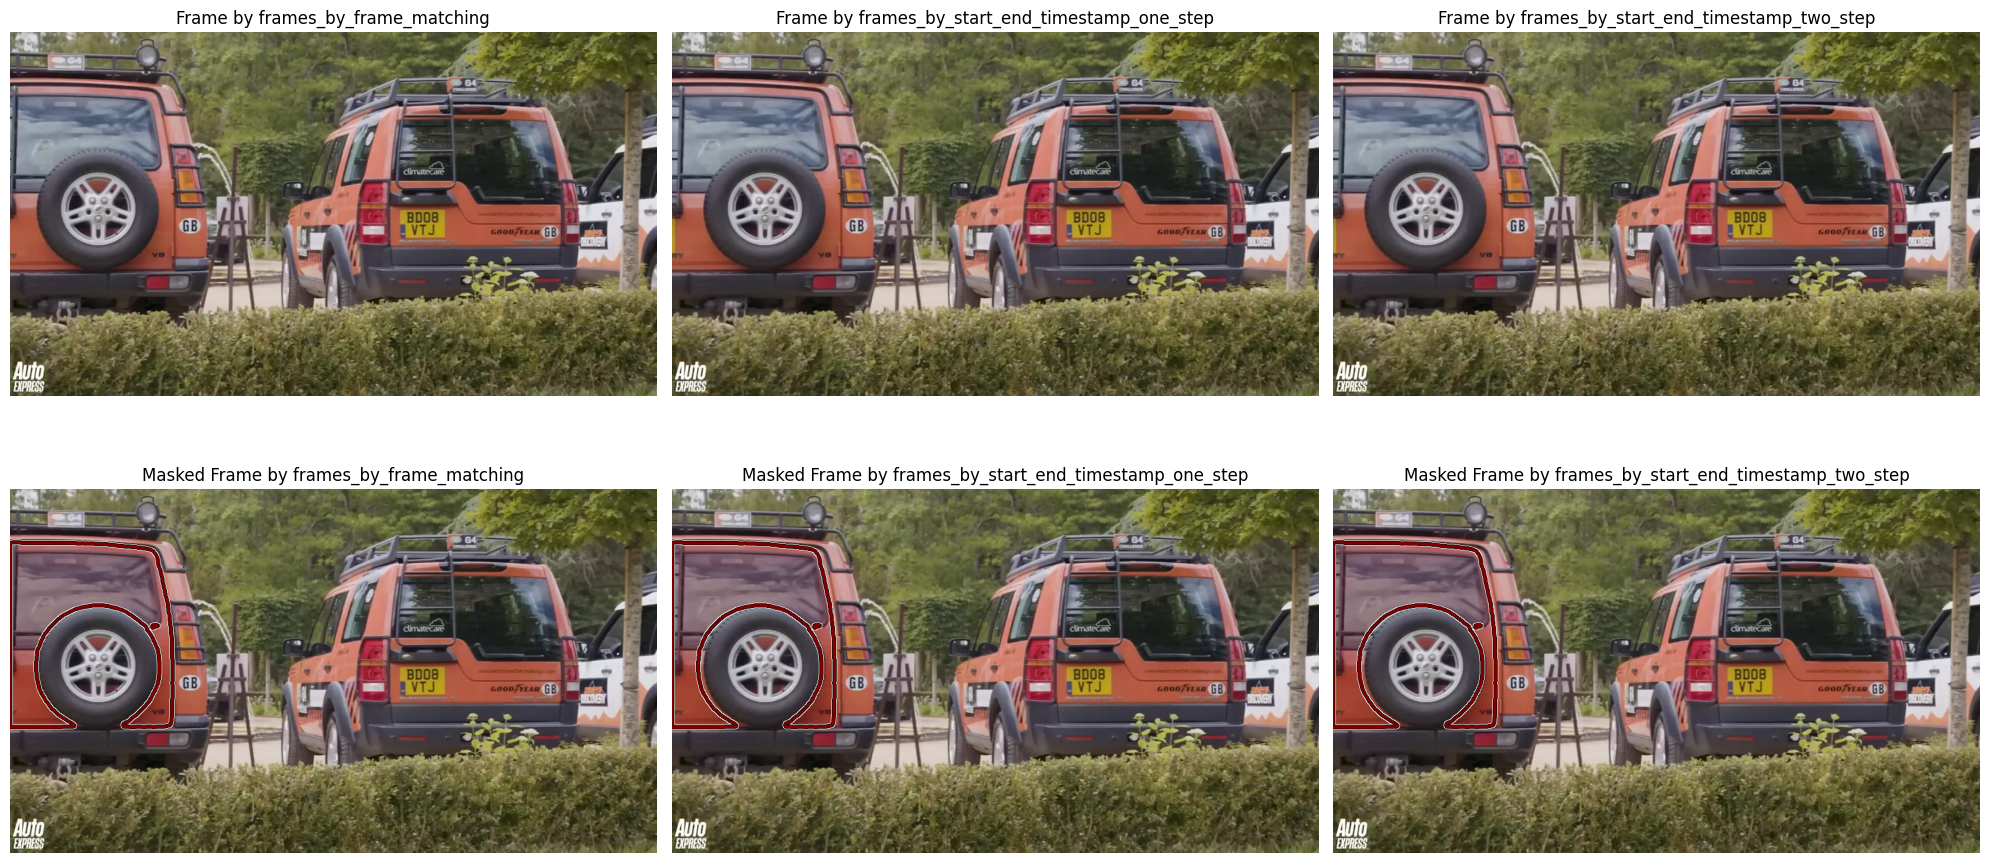

In [57]:
plot_images(saco_yt1b_id="saco_yt1b_000403", masklet_id=2, frame_num=0, df=annot_df)
plt.tight_layout()

/home/tym/code/git_clone/sam3_and_data/data/media/saco_yt1b/frames_by_frame_matching/saco_yt1b_000367/00000.jpg
/home/tym/code/git_clone/sam3_and_data/data/media/saco_yt1b/frames_by_start_end_timestamp_one_step/saco_yt1b_000367/00000.jpg
/home/tym/code/git_clone/sam3_and_data/data/media/saco_yt1b/frames_by_start_end_timestamp_two_step/saco_yt1b_000367/00000.jpg


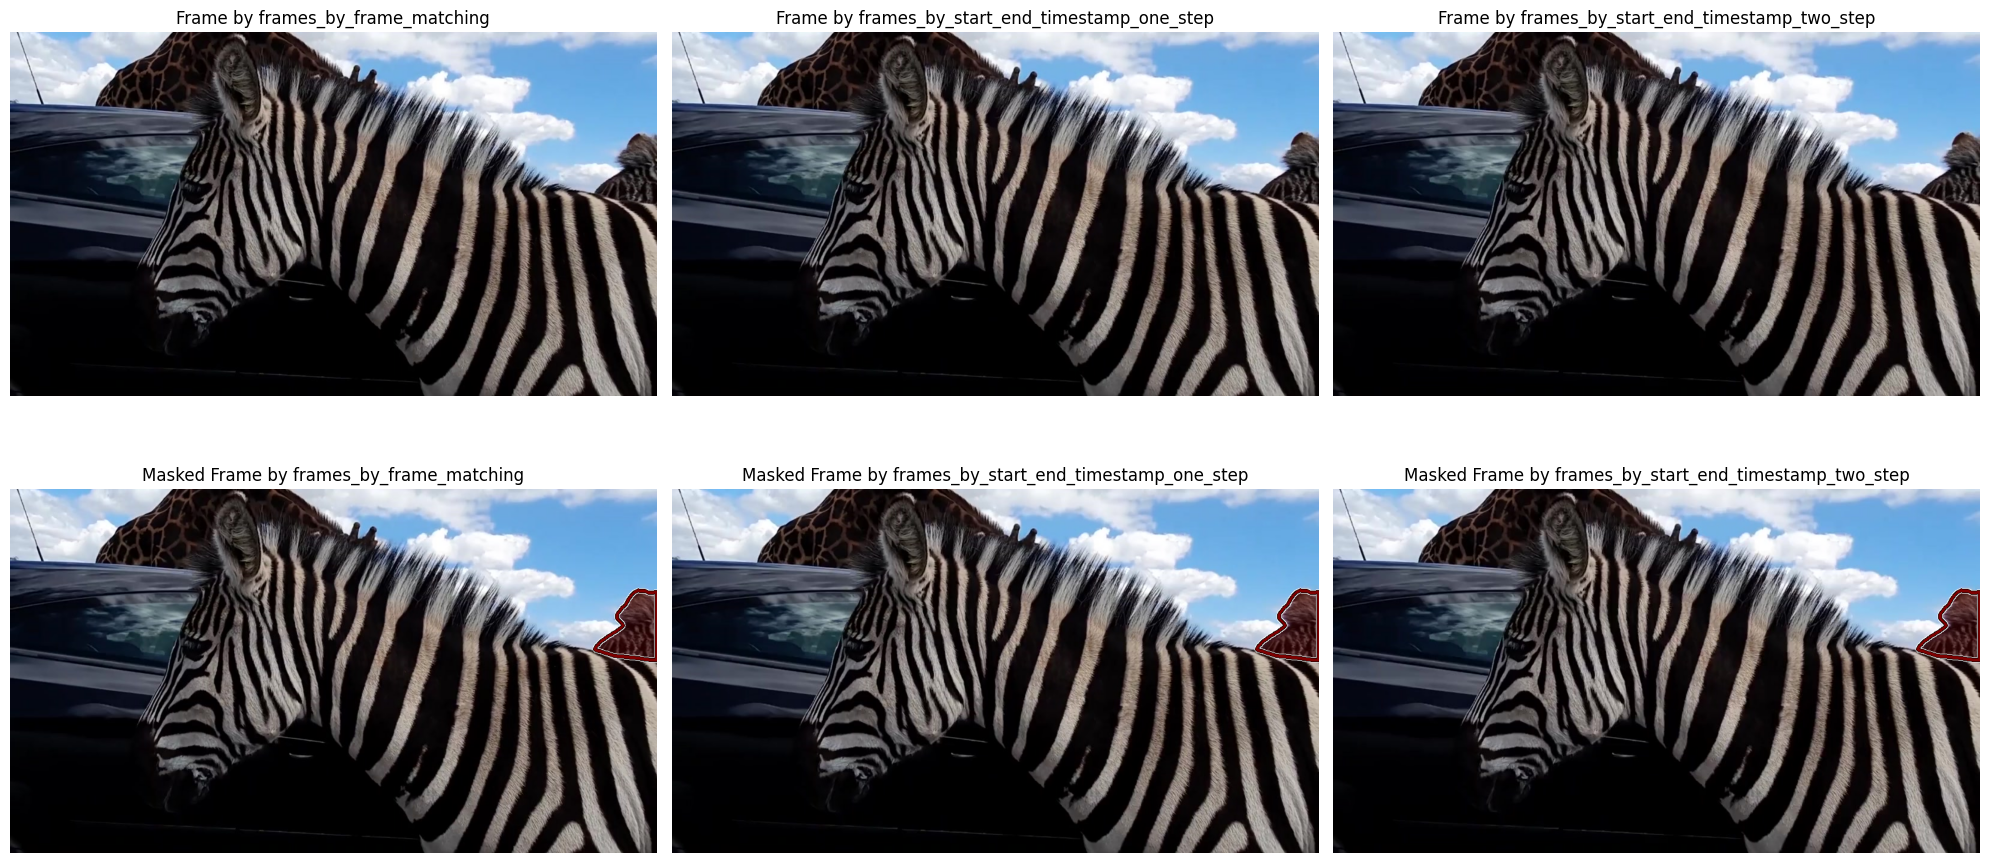

In [58]:
plot_images(saco_yt1b_id="saco_yt1b_000367", masklet_id=0, frame_num=0, df=annot_df)
plt.tight_layout()